### Peut on prédire précisément le prix de vente d'une voiture à partir d'informations telles que le modèle, l'année de mise en circulation, le kilométrage?

> Cette information est utile si un automobiliste souhaite mettre en vente sa voiture au prix du marché pour augmenter ses chances de vendre la voiture à un prix intéressant.

### Les données

> Les données proviennent d'un site de vente en ligne de voiture d'occasion français [La Centrale](https://www.lacentrale.fr). 
* 5000 données ont été récupérées pour le marque BMW seulement.

In [1]:
import pandas as pd 
import pandas 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm 

from sklearn import preprocessing
from sklearn import compose
from sklearn import metrics
from sklearn import model_selection 
from sklearn import set_config

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, Ridge, RidgeCV

set_config(display='diagram')   

import catboost
import xgboost

import shap
shap.initjs()
from pandas_profiling import ProfileReport

from utils import get_model_number
from fc_tools.plotting.bokeh_histogram import BokehHistogram
from fc_tools.pipeline.utils import get_feature_names, SMWrapper
from fc_tools.pipeline.transforms import DropNaTransform, DropZeroTransform, IdentityTransformer, IdentityOrTransform

COLORS = sns.color_palette("deep")
sns.set_palette("deep")
plt.style.use('~/.base_style.mplstyle')

%load_ext autoreload
%autoreload 2

ModuleNotFoundError: No module named 'utils'

In [ ]:
data = pd.read_csv("data/data.csv")
data.head()

In [4]:
ProfileReport(data)

Summarize dataset:   0%|          | 0/25 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

* Creation d'un transformer pour passer de la description du modèle au numéro de série par exemple ```Serie 5``` devient ```5```.
> L'implémentation de ce transformer est faite dans la librairie ```utils.py```. La classe crée implémente la méthode ```_transform``` de l'interface ```Transformer```.

In [5]:
data['model_number'] = data['model'].apply(get_model_number).dropna().astype('int')
data['energy_label'] = preprocessing.LabelEncoder().fit_transform(data['energy'])
data['gearbox_label'] = preprocessing.LabelEncoder().fit_transform(data['gearbox'])

In [6]:
data.head(2)

model                                 version  price  \
0  BMW SERIE 5 F11 TOURING  (F11) (2) TOURING 520D 190 LUXURY BVA8  23500   
1          BMW SERIE 4 F32      (F32) COUPE 430DA XDRIVE 258 SPORT  35500   

   mileage  year  doors  power  energy      gearbox  consumption  \
0    91500  2015      5    190  Diesel  automatique          4.0   
1    54500  2015      2    259  Diesel  automatique          5.0   

   state_number           evaluation  model_number  energy_label  \
0            34      Offre équitable           5.0             0   
1            75  Au-dessus du marché           4.0             0   

   gearbox_label  
0              0  
1              0

In [7]:
pd.DataFrame(data.isna().sum(), columns=["na_values"]).T

model  version  price  mileage  year  doors  power  energy  \
na_values      0        0      0        0     0      0      0       0   

           gearbox  consumption  state_number  evaluation  model_number  \
na_values        0          607             0           0           145   

           energy_label  gearbox_label  
na_values             0              0

### 2.1. Distributions des variables

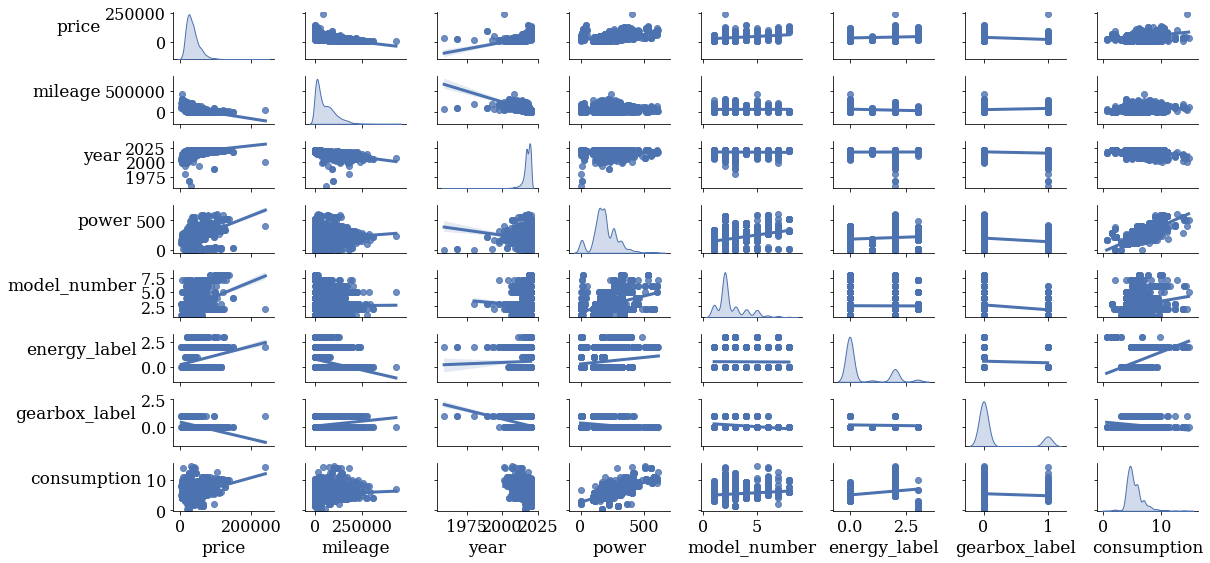

In [8]:
g = sns.pairplot(data[["price", "mileage", "year", "power", "model_number",
                    "energy_label", "gearbox_label", "consumption"]], kind='reg', height=1., aspect=2., diag_kind='kde')
for ax in g.axes.flatten():
    ax.set_ylabel(ax.get_ylabel(), rotation = 0)
    ax.yaxis.get_label().set_horizontalalignment('right')

In [9]:
BokehHistogram(data).histotabs(["price", "mileage", "year", "power", "model_number",
                     "energy_label", "gearbox_label", "consumption"])

### 2.2. Corrélations entre les variables

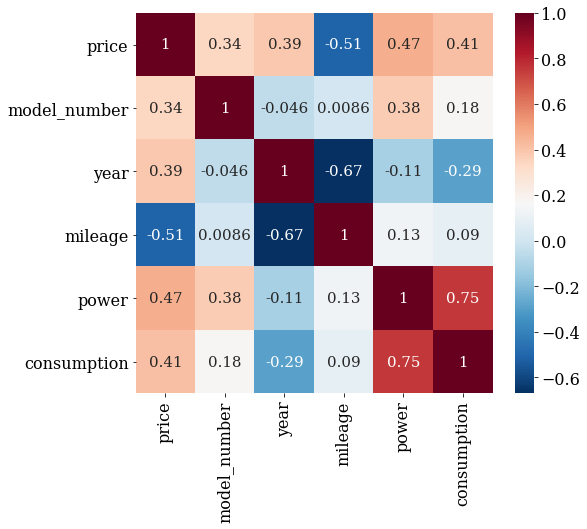

In [10]:
plt.figure(figsize=(8,7))
sns.heatmap(data[["price", "model_number", "year", "mileage", "power", "consumption"]].corr(), cmap="RdBu_r", annot=True);

<a id = '3'></a>
# 3. Regression linéaire sur les données
[Index](#Index)

* Transformations

In [6]:
one_hot_encoder = preprocessing.OneHotEncoder()
power_transform = Pipeline(
    [
        ("scaled_min_max", preprocessing.MaxAbsScaler()),
        ("power_transform", IdentityOrTransform(
            transformation=preprocessing.PowerTransformer(method="box-cox"),
            apply_transformation=True)
        ),
    ]
)

* Column transformer

In [7]:
col_transformer = compose.ColumnTransformer(
    [
        ("one_hot", preprocessing.OneHotEncoder(drop="first"), ["energy", "gearbox"]),
        ("id", IdentityTransformer(), ["model_number"]),
    ] + \
    [
        (f"power_transformed_{i}", power_transform, [i]) for i in ["mileage", "year", "consumption", "power"]
    ], 
)

In [8]:
col_transformer.fit_transform(data[data.power > 0]).shape

(4472, 9)

In [9]:
BokehHistogram(pd.DataFrame(col_transformer.fit_transform(data[data.power > 0]), columns=get_feature_names(col_transformer))).histotabs(get_feature_names(col_transformer))

In [10]:
clean_data_pipeline = Pipeline(
    [
        ("drop_na", DropNaTransform()),
        ("drop_zero_power", DropZeroTransform(["power"])),
    ]
)

cleaned_data = clean_data_pipeline.fit_transform(data)

In [11]:
regression_pipeline = compose.TransformedTargetRegressor(
        regressor=Ridge(),
        transformer=preprocessing.PowerTransformer(method="box-cox"),
    )

pipeline = Pipeline(
    [
        ("preprocessor", col_transformer),
        ("regressor", regression_pipeline)
    ]
)

In [12]:
X = cleaned_data.drop('price', 1)
y = cleaned_data[['price']]
pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('one_hot',
                                                  OneHotEncoder(drop='first'),
                                                  ['energy', 'gearbox']),
                                                 ('id', IdentityTransformer(),
                                                  ['model_number']),
                                                 ('power_transformed_mileage',
                                                  Pipeline(steps=[('scaled_min_max',
                                                                   MaxAbsScaler()),
                                                                  ('power_transform',
                                                                   IdentityOrTransform(transformation=PowerTransformer(method='box-cox')))]),
                                                  ['milea...
                                                                   IdentityOrTransform(transformation=PowerTransformer(method='box-cox')))]),
                                                  ['consumption']),
                                                 ('power_transformed_power',
                                                  Pipeline(steps=[('scaled_min_max',
                                                                   MaxAbsScaler()),
                                                                  ('power_transform',
                                                                   IdentityOrTransform(transformation=PowerTransformer(method='box-cox')))]),
                                                  ['power'])])),
                ('regressor',
                 TransformedTargetRegressor(regressor=Ridge(),
                                            transformer=PowerTransformer(method='box-cox')))])

In [13]:
model_selection.cross_val_score(pipeline, X, y)

array([0.83855835, 0.85419011, 0.87735302, 0.73208083, 0.88638504])

In [14]:
param_grid = {
    f"preprocessor__power_transformed_{i}__power_transform__apply_transformation": [True, False] \
    for i in ["mileage", "year", "consumption", "power"]
} 
param_grid["regressor__transformer"] = [
    preprocessing.PowerTransformer(method="box-cox"), 
    preprocessing.FunctionTransformer(func=np.log, inverse_func=np.exp)
]

#param_grid["regressor__regressor"] = [
#    SMWrapper(sm.OLS),
#    SMWrapper(sm.GLS), 
#    RidgeCV(), 
#    LassoCV()
#]

param_grid["regressor__regressor"] = [
    LinearRegression()
]

search = model_selection.GridSearchCV(
    pipeline,
    param_grid=param_grid,
    verbose=1
)

In [15]:
search.fit(X, y);

Fitting 5 folds for each of 32 candidates, totalling 160 fits


In [16]:
search.best_params_

{'preprocessor__power_transformed_consumption__power_transform__apply_transformation': False,
 'preprocessor__power_transformed_mileage__power_transform__apply_transformation': False,
 'preprocessor__power_transformed_power__power_transform__apply_transformation': True,
 'preprocessor__power_transformed_year__power_transform__apply_transformation': True,
 'regressor__regressor': LinearRegression(),
 'regressor__transformer': FunctionTransformer(func=<ufunc 'log'>, inverse_func=<ufunc 'exp'>)}

0.8607390155714519


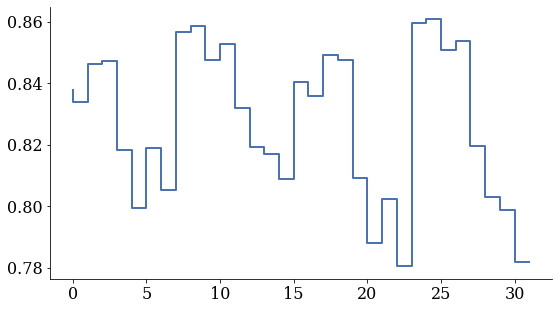

In [17]:
scores = search.cv_results_["mean_test_score"]
print(search.best_score_)
plt.step(range(len(scores)), scores);

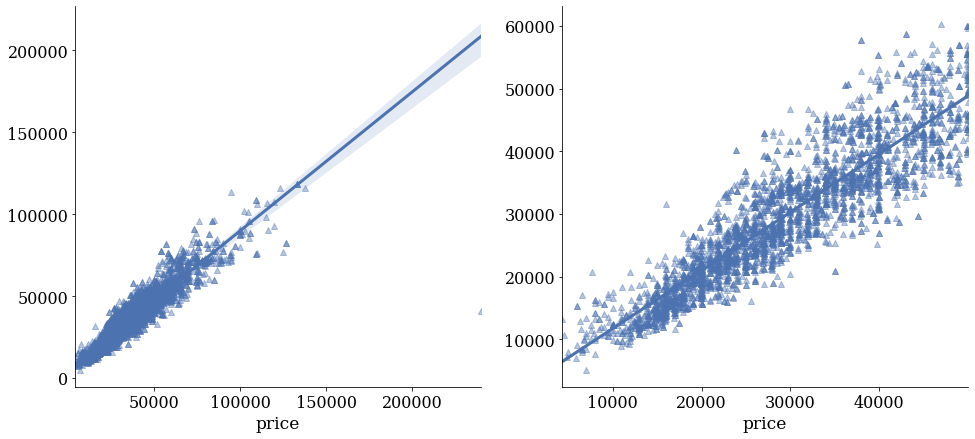

In [23]:
_, ax = plt.subplots(1, 2, figsize=(16, 7))
sns.regplot(x=y, y=search.best_estimator_.predict(X), marker='^', scatter_kws=dict(alpha=0.4), ax=ax[0])
sns.regplot(x=y[y["price"]<50000], y=search.best_estimator_.predict(X[y["price"]<50000]), marker='^', scatter_kws=dict(alpha=0.4), ax=ax[1]);

##  Utilisation de SHAP

In [18]:
model = search.best_estimator_
model = model.fit(X, y)

In [25]:
x_Train = pd.DataFrame(model.named_steps['preprocessor'].fit_transform(X), 
                       columns=get_feature_names(model.named_steps['preprocessor']))

In [26]:
X200 = shap.utils.sample(x_Train, 200)

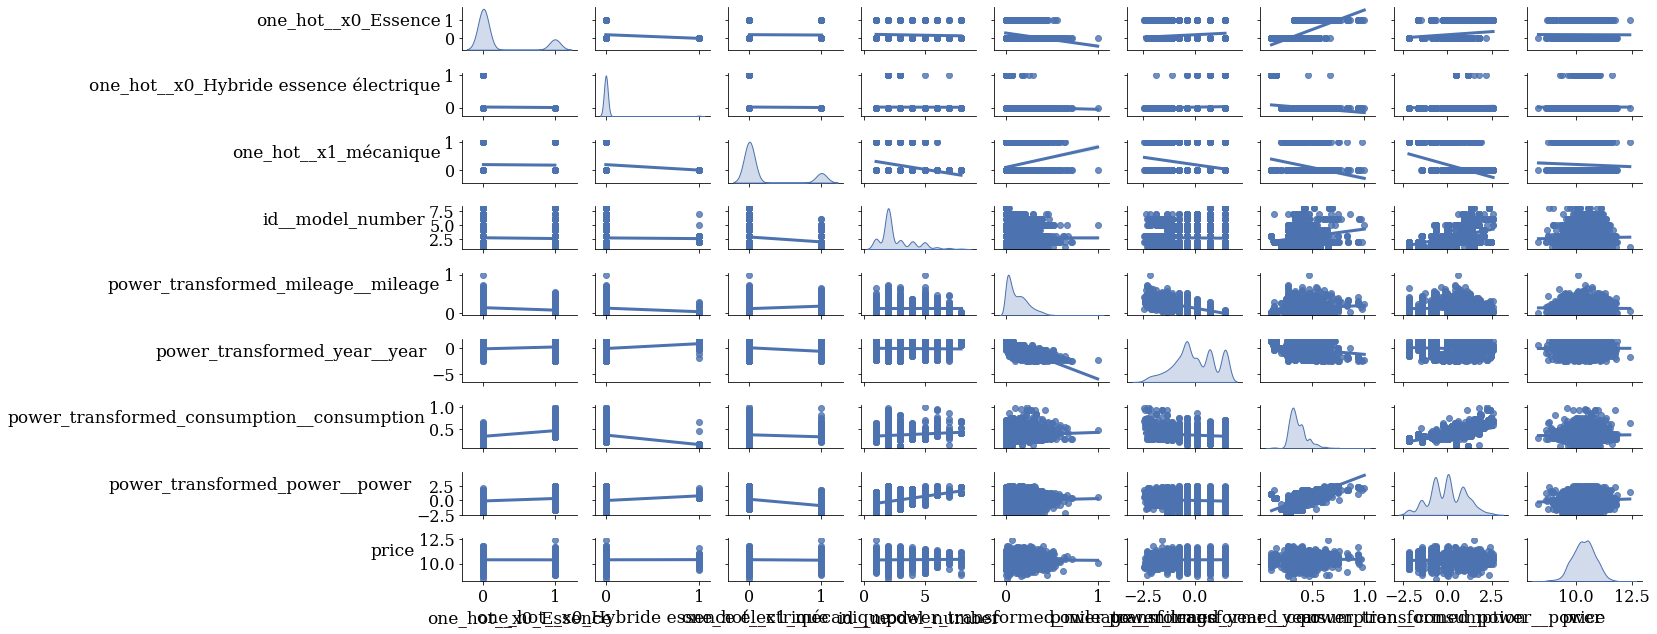

In [27]:
g = sns.pairplot(pd.concat([x_Train, y.apply(np.log)], axis=1), kind='reg', height=1., aspect=2., diag_kind='kde')
for ax in g.axes.flatten():
    ax.set_ylabel(ax.get_ylabel(), rotation = 0)
    ax.yaxis.get_label().set_horizontalalignment('right')

In [28]:
model.named_steps['regressor'].predict(x_Train)

array([[22576.76982533],
       [33490.82014773],
       [37034.25178898],
       ...,
       [26608.23628533],
       [39850.34769744],
       [35629.61343179]])

In [29]:
pred = model.named_steps['regressor']

In [30]:
pred.transformer.inverse_transform(pred.regressor_.predict(x_Train))

array([22576.76982533, 33490.82014773, 37034.25178898, ...,
       26608.23628533, 39850.34769744, 35629.61343179])

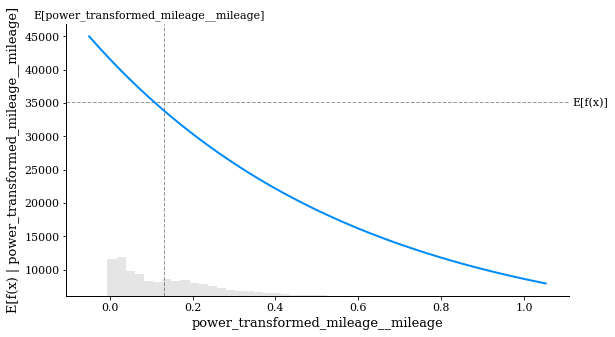

In [31]:
shap.plots.partial_dependence(
    4, model.named_steps['regressor'].predict, x_Train, ice=False,
    model_expected_value=True, feature_expected_value=True
)

In [59]:
# from https://datascience.stackexchange.com/questions/52476/how-to-use-shap-kernal-explainer-with-pipeline-models
def model_predict(model, feature_names, data_asarray):
    data_asframe =  pd.DataFrame(data_asarray, columns=feature_names)
    return model.predict(data_asframe)

In [61]:
X200 = shap.utils.sample(X, 10)
explainer = shap.KernelExplainer(lambda d: model_predict(model, X200.columns, d), X200)
shap_values = explainer.shap_values(X200)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values, X200)

  0%|          | 0/10 [00:00<?, ?it/s]

AssertionError: The shap_values arg looks looks multi output, try shap_values[i].

Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


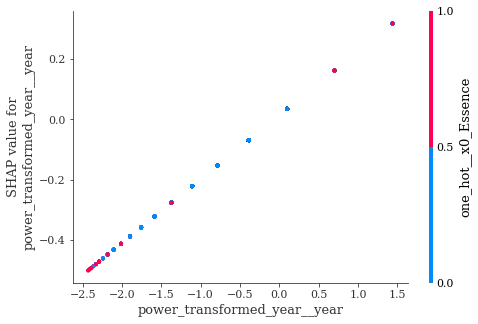

In [105]:
shap_values = explainer.shap_values(x_Train)
shap.dependence_plot(5, shap_values, x_Train)

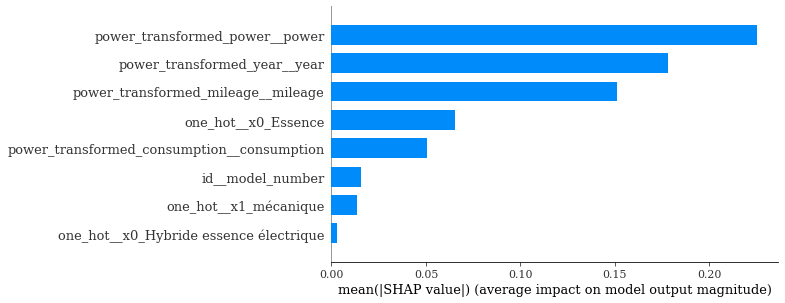

In [106]:
shap.summary_plot(shap_values, x_Train, plot_type="bar")

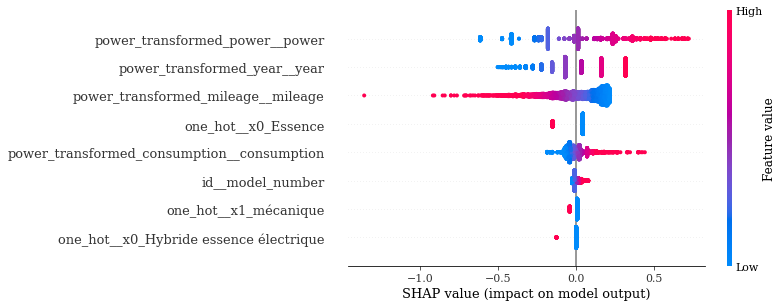

In [107]:
shap.summary_plot(shap_values, x_Train)

### 3.3. Qualification de l'importance des coefficients obtenus

In [ ]:
res.params.index

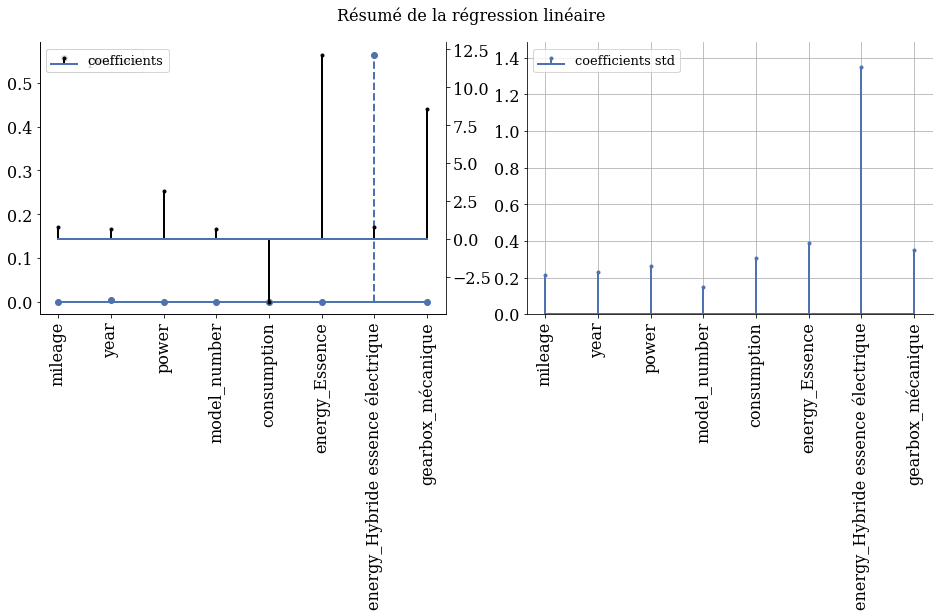

In [16]:
pvalues = res.pvalues # Intercept=0 because variables are centered
coeff_std = res.bse
coefficients = list(res.params)
categories = list(res.params.index)

x = np.linspace(0, len(pvalues), len(pvalues))
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))
ax1.stem(x, pvalues, use_line_collection=True, label="pvalues", 
                                 basefmt='C0', linefmt="--")
ax1.set_xticks(x)
ax1.set_xticklabels(categories, rotation='vertical')
ax1.legend(loc='upper left')

ax1 = ax1.twinx()
ax1.stem(x, coefficients, use_line_collection=True, label="coefficients", 
                         linefmt="k-", basefmt='C0', markerfmt=".k")

ax1.set_xticks(x)
ax1.set_xticklabels(categories, rotation='vertical')
ax1.legend(loc='upper left')
ax1.spines['right'].set_visible(True)


ax2.stem(x, coeff_std, use_line_collection=True, label="coefficients std", basefmt='C0', markerfmt=".")
ax2.set_ylim(0, max(coeff_std)*1.1)
ax2.set_xticks(x)
ax2.set_xticklabels(categories, rotation='vertical')
ax2.legend(loc='upper left')
ax2.grid()

fig.suptitle('Résumé de la régression linéaire', fontsize=16)
plt.show()

* Nous voyons ici l'avantage de la normalisation des variables qui permet d'interpréter directement si une variable est importante pour le problème de régression posé. La p-valeur du test de nullité de chaque coefficient permet de qualifier cette importance. La normalisation permet aussi d'analyser directement la convergence du modèle avec les écarts types des coefficients qui sont faibles relativement aux valeurs des coefficients.

## Utilisation de Catboost

In [34]:
model_catboost = catboost.CatBoostRegressor(silent=True)

In [21]:
X_ = X[["mileage", "year", "consumption", "power", "model_number", "doors", "gearbox_label", "energy_label"]]
X200 = shap.utils.sample(X_, 200)
y200 = shap.utils.sample(y, 200)

In [35]:
model_catboost.fit(X_, y)

In [42]:
model_catboost.save_model('catboost.bin')

(-7480.0, 251680.0, -7686.735976682876, 249670.61065888396)

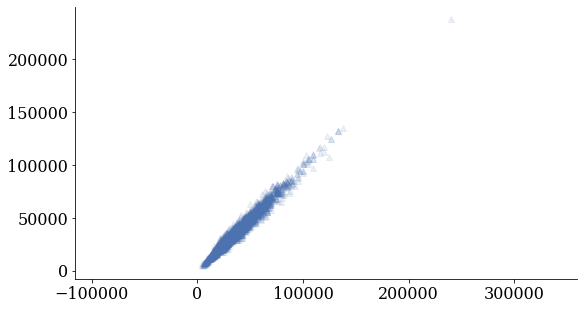

In [23]:
plt.plot(y, model_catboost.predict(X_), "^", alpha=0.1);
plt.axis('equal')

In [120]:
explainer = shap.TreeExplainer(model_catboost)
shap_values = explainer.shap_values(X200, y200)

shap.force_plot(explainer.expected_value, shap_values, X200)

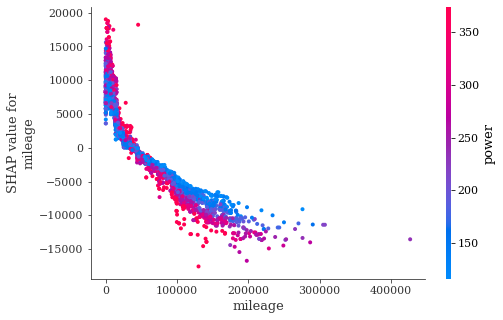

In [125]:
shap_values = explainer.shap_values(X_, y)
shap.dependence_plot("mileage", shap_values, X_)

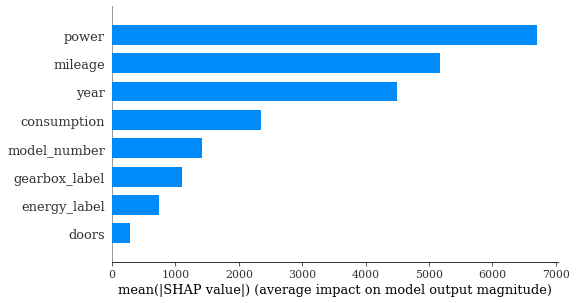

In [126]:
shap.summary_plot(shap_values, X_, plot_type="bar")

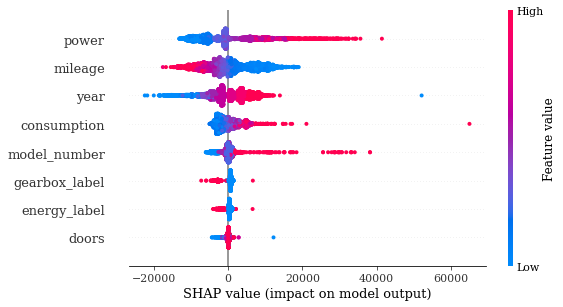

In [127]:
shap.summary_plot(shap_values, X_)

In [24]:
model_selection.cross_val_score(model, X_, y)

array([-1471.76628913, -1472.42274742, -1535.26360264, -1399.80772464,
       -1532.12657894])

## Xgboost 

In [27]:
model = xgboost.XGBRegressor()

param_grid = {
    "colsample_bytree": [0.7],
    "subsample": [0.3, 0.5, 0.7],
    "reg_lambda": [0.1, 1, 10],
    "max_depth": [6, 8, 10]
}

search = model_selection.GridSearchCV(
    model,
    param_grid=param_grid,
    verbose=1
)

In [28]:
search.fit(X_, y)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=None,
                                    verbosity=None),
             param_grid={'colsample_bytree': [0.7], 'max_depth': [6, 8, 10],
                         'reg_lambda': [0.1, 1, 10],
                         'subsample': [0.3, 0.5, 0.7]},
             verbose=1)

In [30]:
search.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=0.1, scale_pos_weight=1, subsample=0.7,
             tree_method='exact', validate_parameters=1, verbosity=None)

0.9025430677524776


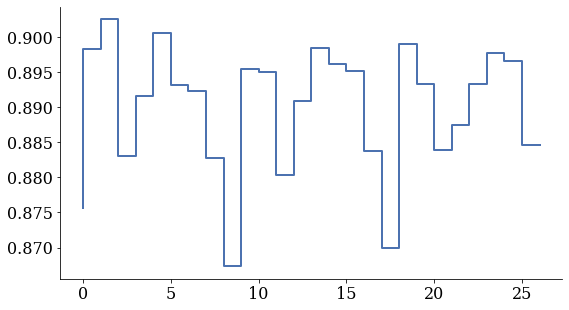

In [29]:
scores = search.cv_results_["mean_test_score"]
print(search.best_score_)
plt.step(range(len(scores)), scores);

In [41]:
search.best_estimator_.save_model('xgboost.model')
search.best_estimator_.save_model('xgboost.json')

In [ ]:
xgboost.

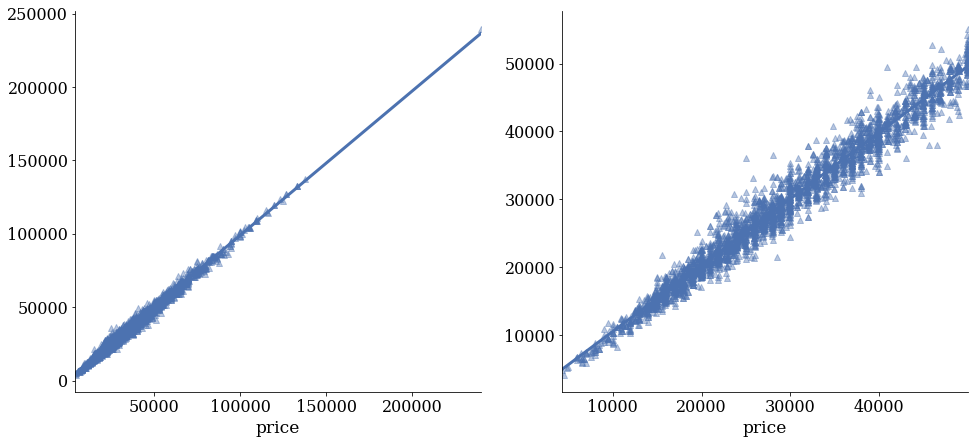

In [39]:
_, ax = plt.subplots(1, 2, figsize=(16, 7))
sns.regplot(x=y, y=search.best_estimator_.predict(X_), marker='^', scatter_kws=dict(alpha=0.4), ax=ax[0])
sns.regplot(x=y[y["price"]<50000], y=search.best_estimator_.predict(X_[y["price"]<50000]), marker='^', scatter_kws=dict(alpha=0.4), ax=ax[1]);

## MPL Regressor

In [69]:
from sklearn.neural_network import MLPRegressor

In [120]:
model_mlp = MLPRegressor(hidden_layer_sizes=[100, 10], max_iter=1000)

In [121]:
model_mlp.fit(X_, y["price"])

MLPRegressor(hidden_layer_sizes=[100, 10], max_iter=1000)

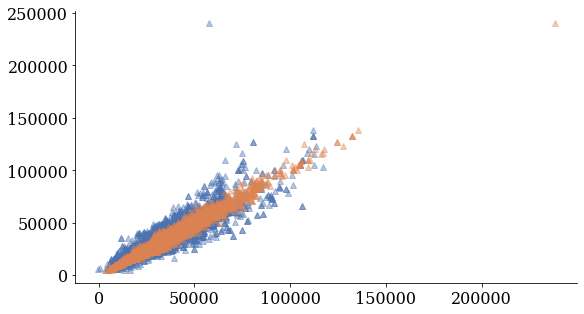

In [122]:
plt.plot(model_mlp.predict(X_), y, '^', alpha=0.4)
plt.plot(model.predict(X_), y, '^', alpha=0.4)